In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Softmax as Softmax
from keras.layers import Conv2D as CNN
from keras.layers import MaxPooling2D as MaxPool
from keras.layers import Flatten as Flatten

from tensorflow.keras.utils import to_categorical
import keras as keras

from numpy import array
import numpy as np

import matplotlib.pyplot as plt
import time

2023-12-14 13:23:53.312239: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 13:23:53.312341: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 13:23:53.312379: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 13:23:54.833118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
N_digits = 60000
D_Size = 784
D_bytes = N_digits * D_Size
D_rows = N_digits * 28

In [3]:
MNIST_file = open ("../Data/train-images.idx3-ubyte", "rb")
z = MNIST_file.read (16 + D_bytes)
len (z)

47040016

In [4]:
# 4 words of metadata in the header, skip
digits_raw = z[16:(16 + D_bytes)]

w = np.empty (shape=(D_rows, 28))

In [5]:
print (len (digits_raw))

# convert the bytes to Numpy floats for Keras
for i in range (0, D_rows) :
    for j in range (0,28) :
        w[i, j] = float (digits_raw[i*28 + j])/255

47040000


In [6]:
# Re-shape the training set to reflect their structure
# 60,000 hand-written digits, 28x28 pixels
Training = w.reshape (N_digits, 28, 28)

np.shape (Training)

(60000, 28, 28)

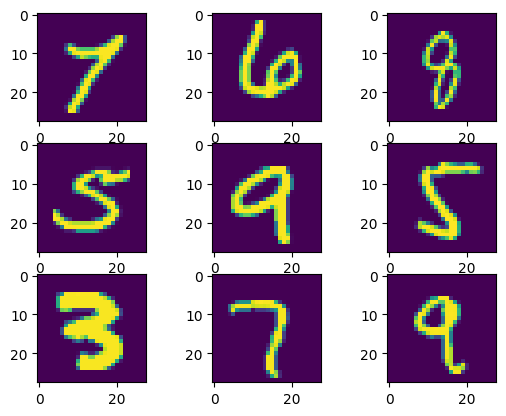

In [7]:
# Visual inspection, verify shaping worked
look = np.random.uniform (0, 60000, 9)

dummy, Z = plt.subplots (3, 3)

for i in range (0, 3):
    for j in range (0, 3):
        Z[i, j].imshow (Training[int (look [i*3 + j])])



In [8]:
# Load the labels
#
# Same procedure as above.  Move past header and convert bytes
# to Numpy floats for use as categories.
#

Labels_file = open ("../Data/train-labels.idx1-ubyte", "rb")
Labels_raw = Labels_file.read (8 + N_digits)

Labels = np.empty (N_digits)
for i in range (0, N_digits):
    Labels[i] = int (Labels_raw[8 + i])

RawLabels = Labels
# The classes of the digits, 0:9
# Answers = range (0, 10)

Labels = to_categorical (Labels)


In [9]:

# Verify hot encoding

Labels[58259]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [10]:
# Build the model

model = Sequential()                                                 

# Convolutional (filter) layer.  5 planes of 3x3 filters
model.add (CNN (5, kernel_size=3, activation="relu", input_shape=(28,28,1)))

# Maxpool layer, samples of 2x2
model.add (MaxPool (pool_size=(2, 2), strides=(1,1), padding="valid"))

# The output of the above layers are arrays, turn them into vectors
# for the neural network
model.add (Flatten ())

# 50 neurons
model.add (Dense(50, activation='relu'))

# 10 classes (digits 0:9)
model.add (Dense (10, activation='softmax'))

model.compile (loss='categorical_crossentropy', optimizer='SGD')

model.summary ()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 5)         50        
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 5)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3125)              0         
                                                                 
 dense (Dense)               (None, 50)                156300    
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
Total params: 156860 (612.73 KB)
Trainable params: 156860 (612.73 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [11]:
Nepochs = 5

start = time.time ()

h = model.fit (Training, Labels, epochs=Nepochs, verbose=True)

dt = time.time () - start
print (dt)


Epoch 1/5
1875/1875 [==============================] - 28s 14ms/step - loss: 0.3751
Epoch 2/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1986
Epoch 3/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1546
Epoch 4/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1297
Epoch 5/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1115
136.53987741470337


0.11152174323797226


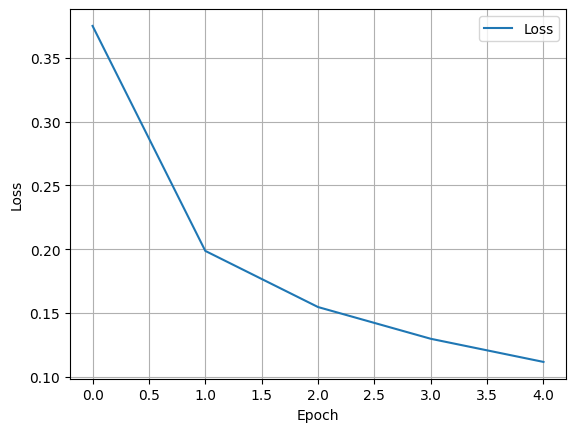

In [12]:
def LossHistory (history):
  plt.plot (history.history['loss'], label='Loss')
  plt.xlabel ('Epoch')
  plt.ylabel ('Loss')
  plt.legend ()
  plt.grid (True)
  plt.show ()

print (h.history['loss'][Nepochs - 1])
LossHistory (h)


In [13]:
Z = model.predict (Training, verbose=False)

predictions = Z.argmax (1)

In [14]:
Z.argmax (1).shape

(60000,)

In [15]:
sum (predictions == RawLabels) / 60000

0.9710166666666666

In [16]:
wrong = list ()

for i in range (20000, 20100):
    if predictions[i] != RawLabels[i]:
        wrong.append (i)

len (wrong)

4

In [17]:
wrong

[20016, 20050, 20068, 20072]

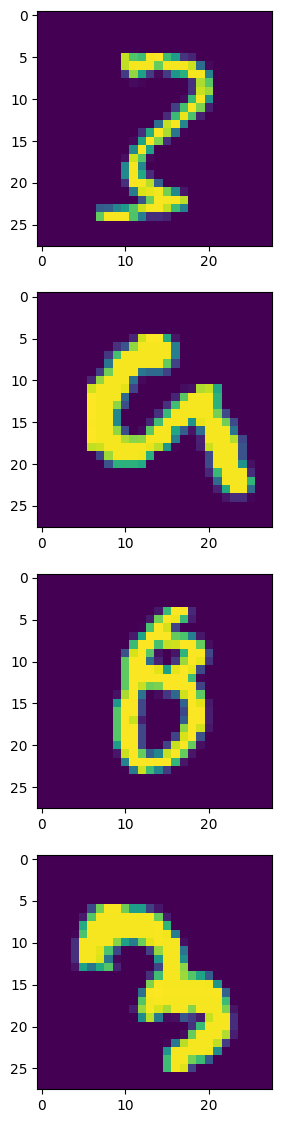

In [18]:
work = len (wrong)

dummy, Z = plt.subplots (work, figsize = (14,14))

for i in range (0, work):
    Z[i].imshow (Training [wrong [i]])

In [19]:
#
# How well does our model generalize?  We need data that it is have never
# seen before: a test set.
#

N_digits = 10000
D_Size = 784
D_bytes = N_digits * D_Size
D_rows = N_digits * 28

MNIST_file = open ("../Data/t10k-images.idx3-ubyte", "rb")
z = MNIST_file.read (16 + D_bytes)
len (z)

# 4 words of metadata in the header, skip
digits_raw = z[16:(16 + D_bytes)]
w = np.empty (shape=(D_rows, 28))

print (len (digits_raw))

# convert the bytes to Numpy floats for Keras
for i in range (0, D_rows) :
    for j in range (0,28) :
        w[i, j] = float (digits_raw[i*28 + j])/255

# Re-shape the training set to reflect their structure
# 10,000 hand-written digits, 28x28 pixels
Training = w.reshape (N_digits, 28, 28)

np.shape (Training)

# Load the labels
#
# Same procedure as above.  Move past header and convert bytes
# to Numpy floats for use as categories.
#

Labels_file = open ("../Data/t10k-labels.idx1-ubyte", "rb")
Labels_raw = Labels_file.read (8 + N_digits)

Labels = np.empty (N_digits)
for i in range (0, N_digits):
    Labels[i] = int (Labels_raw[8 + i])

# The classes of the digits, 0:9
# Answers = range (0, 10)

# Labels = to_categorical (Labels)


7840000


In [20]:
Z = model.predict (Training, verbose=False)

predictions = Z.argmax (1)
sum (predictions == Labels) / 10000


0.97